<a href="https://colab.research.google.com/github/carlosherediapimienta/Quantum_Neural_Network/blob/main/Titanic_Quantum_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries installation

In [1]:
!pip install qiskit
!pip install qiskit-machine-learning
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.9/306.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512411 sha256=f10a1420b2f3e453713028105810ff0bcb331ec87c19256bfb

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data Manipulation:

In [3]:
import pandas as pd

test = pd.read_csv('/content/test.csv')
train = pd.read_csv("/content/train.csv")

In [4]:
# Replace female/male with 0/1
train['Sex'].replace(['female','male'], [0,1], inplace=True)
test['Sex'].replace(['female','male'], [0,1], inplace=True)

In [5]:
train_features = train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
train_features.Age.fillna(train_features.Age.mean(), inplace=True)
train_features.Age = train_features.Age.astype(int)
train_labels = train['Survived']

In [6]:
from sklearn.preprocessing import MinMaxScaler

train_features = MinMaxScaler().fit_transform(train_features)

# Variational Quantum Classifier

## ZZFeature MAP definition:

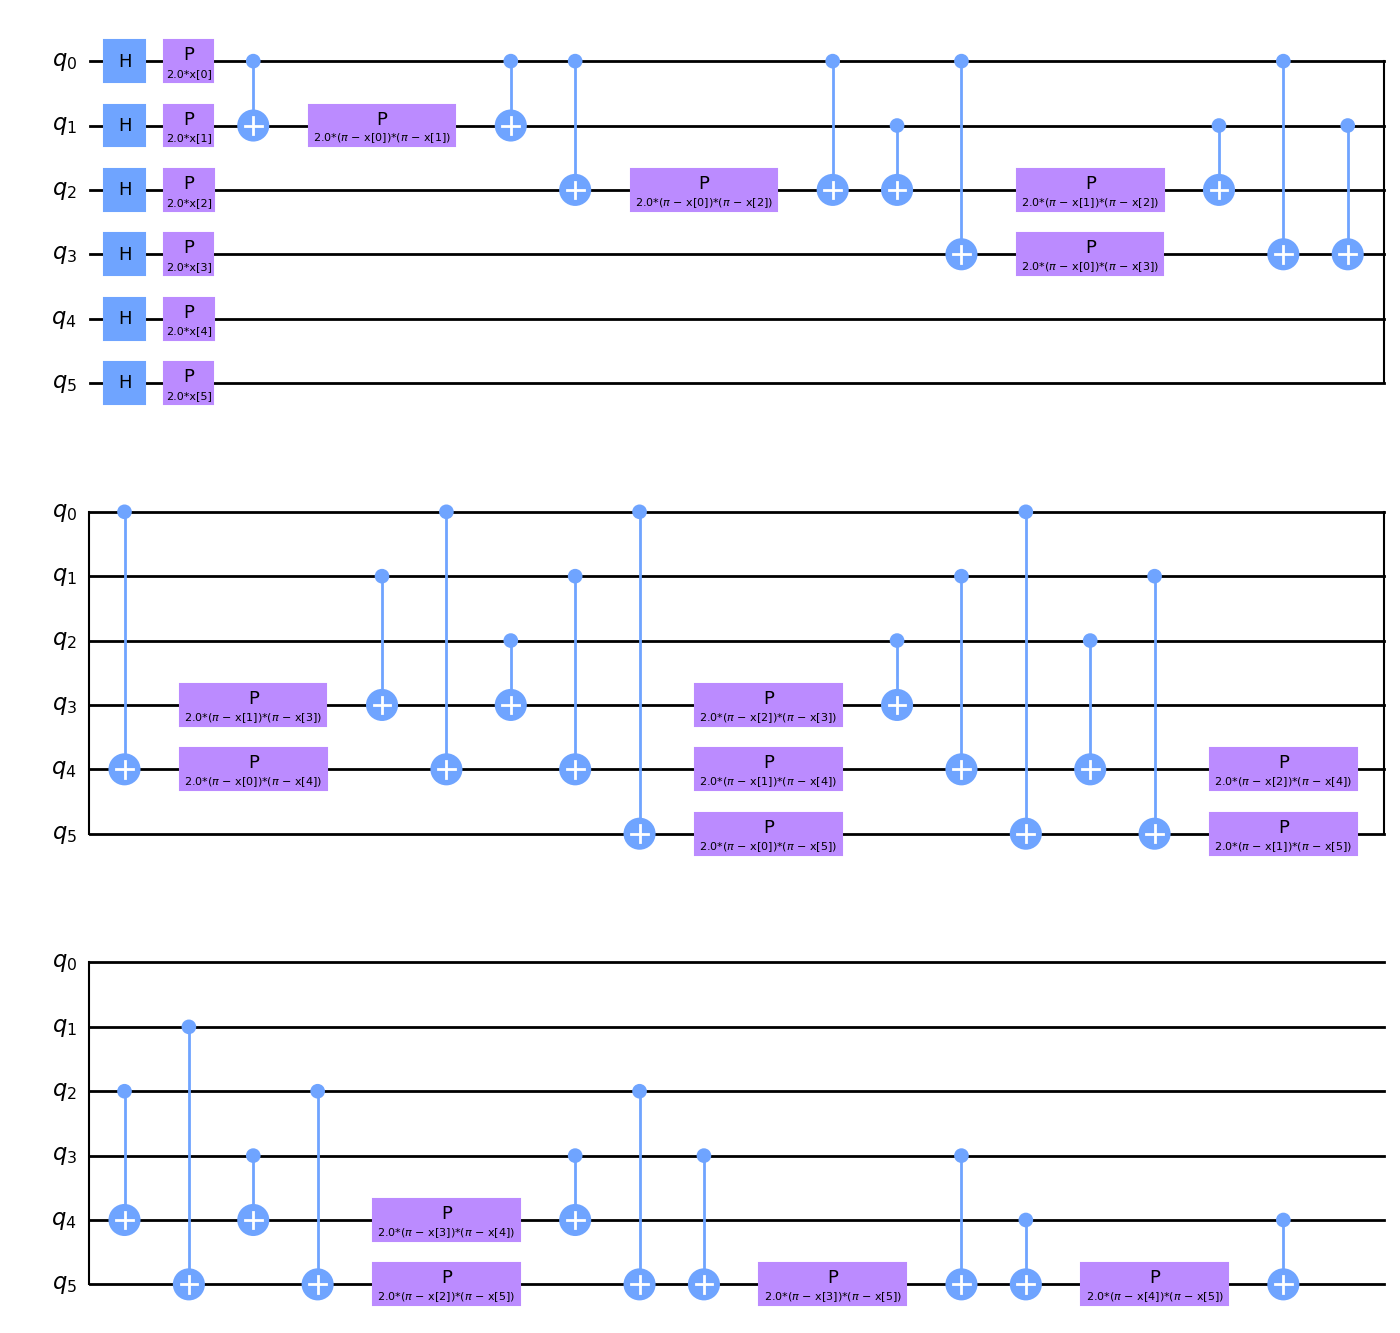

In [7]:
from qiskit.circuit.library import ZZFeatureMap

num_features = train_features.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

## Ansatz:

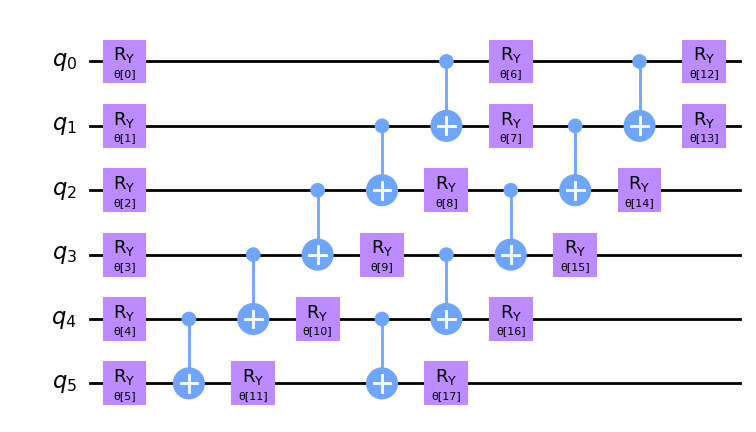

In [8]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=2)
ansatz.decompose().draw(output="mpl", fold=20)

## Optimizer:

In [9]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

## Sampler:

In [10]:
from qiskit.primitives import Sampler

sampler = Sampler(options={"shots": 512})

In [11]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

## Training Variational Quantum Classifier (VQC)

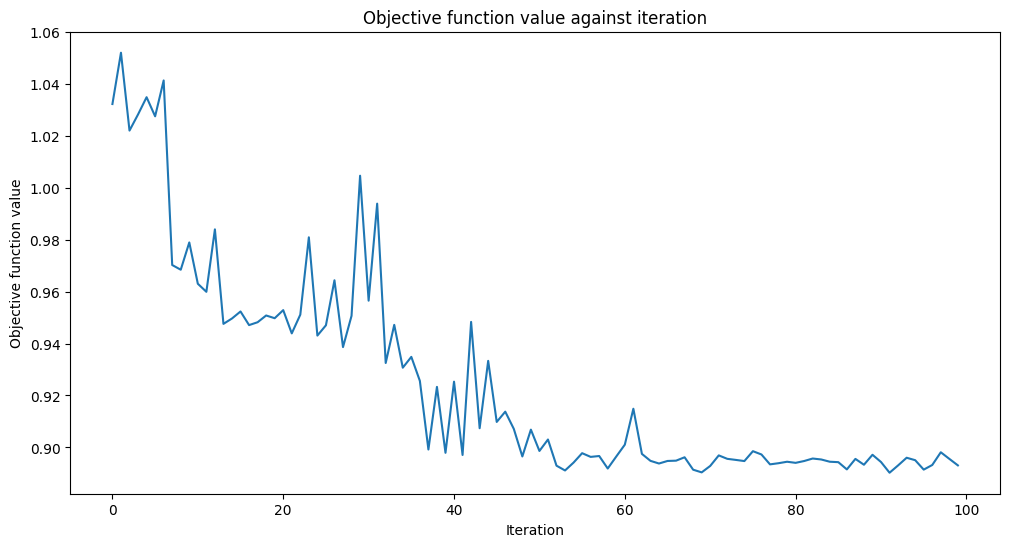

Training time: 1031 seconds


In [12]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels.values)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [13]:
train_acc = vqc.score(train_features, train_labels)
print(f'Accuracy on the training data: {round(train_acc, 2) * 100}%')

Accuracy on the training data: 69.0%


## Predictions:

In [14]:
test_features = test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
test_features.Age.fillna(test_features.Age.mean(), inplace=True)
test_features.Age = test_features.Age.astype(int)
test_features.Fare.fillna(test_features.Fare.mean(), inplace=True)

In [15]:
test_features = MinMaxScaler().fit_transform(test_features)

In [16]:
y = vqc.predict(test_features) # predictions vector